In [2]:
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
import cv2

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 
    
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "weights/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [59]:

img_root_pth= "/home/gongran/Code/CF-3DGS/data/billy_9-23/test/input"
img_name_list = os.listdir(img_root_pth)
img_name_list.sort()
img_list = []
for img_name in img_name_list:
    image = cv2.imread(os.path.join(img_root_pth, img_name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_list.append(image)

In [33]:
%matplotlib widget


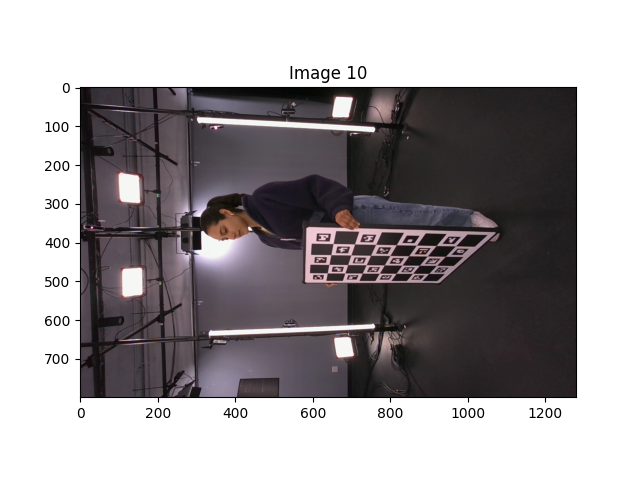

Mask saved to: /home/gongran/Code/segment-anything/notebooks/output/masks/mask_rgb_10.png
Masked image saved to: /home/gongran/Code/segment-anything/notebooks/output/masked_images/mask_10.png


In [61]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import cv2  # For image processing (if needed)

# Set up the index and figure
current_idx = 10
fig, ax = plt.subplots()
keypoint_list = [[] for _ in range(len(img_list))]
label_list = [[] for _ in range(len(img_list))]

current_mask = None
output_root_pth = "/home/gongran/Code/segment-anything/notebooks/output"
mask_output_pth = os.path.join(output_root_pth, "masks")
masked_img_output_pth = os.path.join(output_root_pth, "masked_images")
# Create output directories if they don't exist
os.makedirs(mask_output_pth, exist_ok=True)
os.makedirs(masked_img_output_pth, exist_ok=True)

# Example detection function (replace with your own)
def detect_mask():
    # Dummy mask (replace this with actual detection logic)
    input_point = np.array(keypoint_list[current_idx])
    input_label = np.array(label_list[current_idx])
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    combined_mask = np.logical_or.reduce(masks)
    global current_mask
    current_mask = combined_mask
    return combined_mask

def generate_mask():
    combined_mask = detect_mask()
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = combined_mask.shape[-2:]
    mask_image = combined_mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    # Clear previous mask
    for artist in ax.images[1:]:  # Skip the first image (original image)
        artist.remove()
    # Maintain markers (stars)
    for (x, y), label in zip(keypoint_list[current_idx], label_list[current_idx]):
        color = 'yellow' if label == 1 else 'red'
        ax.plot(x, y, marker='*', color=color, markersize=15)
    ax.imshow(mask_image, alpha=0.5, cmap='jet')  # Overlay the mask on the image
    fig.canvas.draw()
    
def show_masked_image():
    if current_mask is None:
        print("No mask generated yet. Please generate a mask first.")
        return
    
    # Create a copy of the current image
    masked_image = img_list[current_idx].copy()
    
    # Apply the mask
    masked_image[~current_mask] = 0  # Set background to black
    
    # Create a new figure for the masked image
    masked_fig, masked_ax = plt.subplots(figsize=(10, 10))
    
    # Display the masked image
    masked_ax.imshow(masked_image)
    masked_ax.set_title(f"Masked Image {current_idx}")
    
    # Remove axis ticks
    masked_ax.set_xticks([])
    masked_ax.set_yticks([])
    
    # Display the new figure
    display(masked_fig)
    plt.close(masked_fig)
    
    

def save_mask():
    # Define output paths
    # Save the combined mask
    mask_filename = img_name_list[current_idx].replace('rgb', 'mask')
    mask_filepath = os.path.join(mask_output_pth, mask_filename)
    plt.imsave(mask_filepath, current_mask, cmap='gray')

    # Create and save the masked image
    masked_image = img_list[current_idx].copy()
    masked_image[~current_mask] = 0  # Set background to black
    masked_img_filename = img_name_list[current_idx]
    masked_img_filepath = os.path.join(masked_img_output_pth, masked_img_filename)
    plt.imsave(masked_img_filepath, masked_image)

    print(f"Mask saved to: {mask_filepath}")
    print(f"Masked image saved to: {masked_img_filepath}")

def clear_all():
    global keypoint_list, label_list
    keypoint_list[current_idx] = []
    label_list[current_idx] = []
    plot_image(current_idx)

# Plot the current image
def plot_image(idx):
    image = img_list[idx]
    predictor.set_image(image)
    ax.clear()
    ax.imshow(image)
    ax.set_title(f"Image {idx}")
    fig.canvas.draw()

# Update the plot when changing images
def update_image(change):
    global current_idx
    current_idx = (current_idx + change) % len(img_list)
    plot_image(current_idx)


# Capture the click event and plot a star
def on_click(event):
    if event.inaxes == ax:
        x, y = int(event.xdata), int(event.ydata)
        if event.button == 1:  # Left click
            color = 'yellow'
            label = 1
        elif event.button == 3:  # Right click
            color = 'red'
            label = 0
        else:
            return  # Ignore other mouse buttons
        
        ax.plot(x, y, marker='*', color=color, markersize=15)
        fig.canvas.draw()
        keypoint_list[current_idx].append([x,y])
        label_list[current_idx].append(label)

# Create buttons for navigation
generate_button = widgets.Button(description="Generate Mask")
next_button = widgets.Button(description="Next")
save_button = widgets.Button(description="Save Mask")
clear_button = widgets.Button(description="Clear All")
show_masked_image_button = widgets.Button(description="Show Masked Image")

# Attach button functionality
generate_button.on_click(lambda _: generate_mask())
next_button.on_click(lambda _: update_image(1))
save_button.on_click(lambda _: save_mask())
clear_button.on_click(lambda _: clear_all())
show_masked_image_button.on_click(lambda _: show_masked_image())
# Display widgets and figure
display(widgets.HBox([generate_button, save_button, clear_button,show_masked_image_button, next_button]))
plot_image(current_idx)

# Connect the click event to the figure

fig.canvas.mpl_connect('button_press_event', on_click)
plt.show()


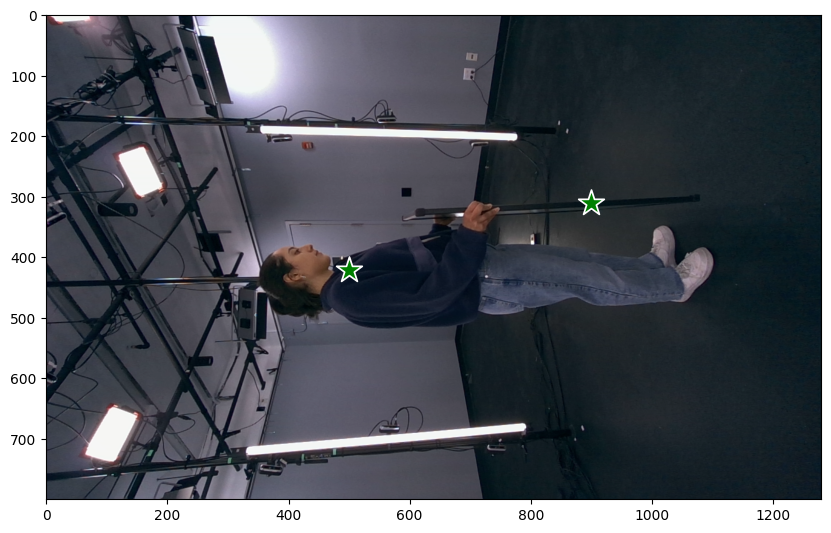

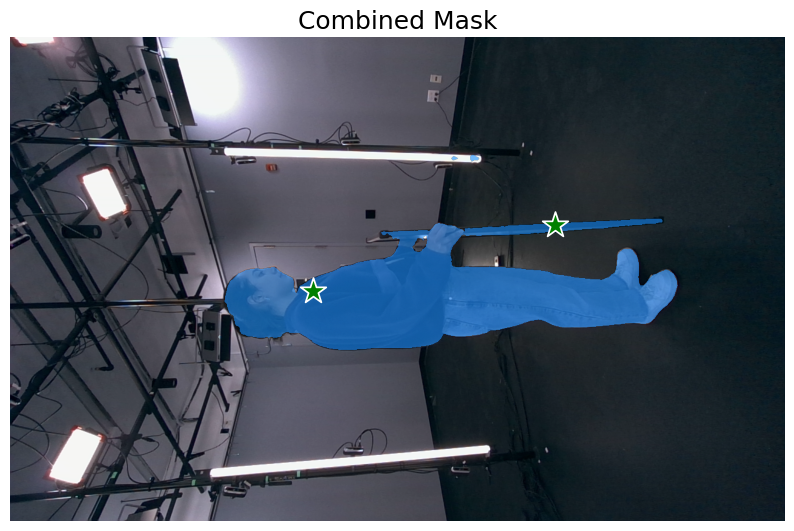

In [22]:
import ipywidgets as widgets
from IPython.display import display

idx = 2
predictor.set_image(img_list[idx])
input_point = np.array([[500,420],[900,310]])
input_label = np.array([1,1])
plt.figure(figsize=(10,10))
plt.imshow(img_list[idx])
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
combined_mask = np.logical_or.reduce(masks)

# Show combined mask
plt.figure(figsize=(10,10))
plt.imshow(img_list[idx])
show_mask(combined_mask, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.title("Combined Mask", fontsize=18)
plt.axis('off')
plt.show()


In [20]:

# Define output paths
output_root_pth = "/home/gongran/Code/CF-3DGS/data/test"
mask_output_pth = os.path.join(output_root_pth, "masks")
masked_img_output_pth = os.path.join(output_root_pth, "masked_images")

# Create output directories if they don't exist
os.makedirs(mask_output_pth, exist_ok=True)
os.makedirs(masked_img_output_pth, exist_ok=True)

# Save the combined mask
mask_filename = f"mask_{img_name_list[idx]}"
mask_filepath = os.path.join(mask_output_pth, mask_filename)
plt.imsave(mask_filepath, combined_mask, cmap='gray')

# Create and save the masked image
masked_image = img_list[idx].copy()
masked_image[~combined_mask] = 0  # Set background to black
masked_img_filename = f"masked_{img_name_list[idx]}"
masked_img_filepath = os.path.join(masked_img_output_pth, masked_img_filename)
plt.imsave(masked_img_filepath, masked_image)

print(f"Mask saved to: {mask_filepath}")
print(f"Masked image saved to: {masked_img_filepath}")



Mask saved to: /home/gongran/Code/CF-3DGS/data/test/masks/mask_rgb_05.png
Masked image saved to: /home/gongran/Code/CF-3DGS/data/test/masked_images/masked_rgb_05.png


In [ ]:
for i, filename in enumerate(sorted(os.listdir(mask_dir))):
        old_path = os.path.join(mask_dir, filename)
        new_filename = f"mask_{i:02d}.png"
        new_path = os.path.join(mask_dir, new_filename)
        os.rename(old_path, new_path)
    
    # Rename masked image files
    masked_img_dir = os.path.join(masked_img_output_pth, img_name_list[idx])
    for i, filename in enumerate(sorted(os.listdir(masked_img_dir))):
        old_path = os.path.join(masked_img_dir, filename)
        new_filename = f"rgb_{i:02d}.png"
        new_path = os.path.join(masked_img_dir, new_filename)
        os.rename(old_path, new_path)
    os.makedirs(os.path.join(mask_output_pth, img_name_list[idx]), exist_ok=True)
    os.makedirs(os.path.join(masked_img_output_pth, img_name_list[idx]), exist_ok=True)